# Create Moderate Panels

Import map tools, set up projection, define city locations

In [1]:
from map_helper import *
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

from_proj = ccrs.PlateCarree()
projection = cartopy.crs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                            false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

cities = {'Denver, CO':(-104.9903, 39.7392),
          'Omaha, NE': (-95.9345, 41.2565),
          'Columbus, OH': (-82.9988, 39.9612),
          'Albany, NY': (-73.7562, 42.6526),
          'Charlotte, NC': (-80.8431, 35.2271),
          'San Antonio, TX': (-98.4936, 29.4241),
          'Oklahoma City, OK':(-97.5164, 35.4676), 
          'Tuscaloosa, AL': (-87.5692, 33.2098), 
          'St. Louis, MO': (-90.1994, 38.6270),
          'Minneapolis, MN': (-93.2650, 44.9778), 
          'Orlando, FL': (-81.3792, 28.5383), 
          'Bismarck, ND': (-100.773703, 46.801942)}

out_dir = "../figures/moderate/"

Set up code to generate dynamic legends using colors, boundaries, etc.

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap
from copy import deepcopy

coords = xr.open_dataset('../data/nam212.nc')

lats = coords.gridlat_212.values
lons = coords.gridlon_212.values

def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    '''
    Takes an axis and adds an SPC-color legend to the map
    '''

    legend_handles = []

    for i in range(len(bounds)):
                 
        label = bounds[i]

        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)

        legend_handles.append(patch)

    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    
    return ax

def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors, mask=True, extend='up'):
    
    cmap = ListedColormap(map_colors)
    
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)

    ax = plt.subplot(1,1,1,projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    if mask:
    
        res = np.ma.masked_where(pper_subset.values == 0, pper_subset.values)
        
    else:
        
        res = deepcopy(pper_subset.values)


    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                        cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        
    labels = []

    for i in range(len(map_color_scale)-1):
    
        val1 = map_color_scale[i]
        val2 = map_color_scale[i+1]

        labels.append("≥ {}".format(val1))
        
    legend_handles = generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    
    return ax

# Draw the maps for each tornado pper threshold

In [3]:
#Set label locations

plet_x = .93
plet_y = .925

plab_x = .025
plab_y = .95

maxlab_x = .025
maxlab_y = .24

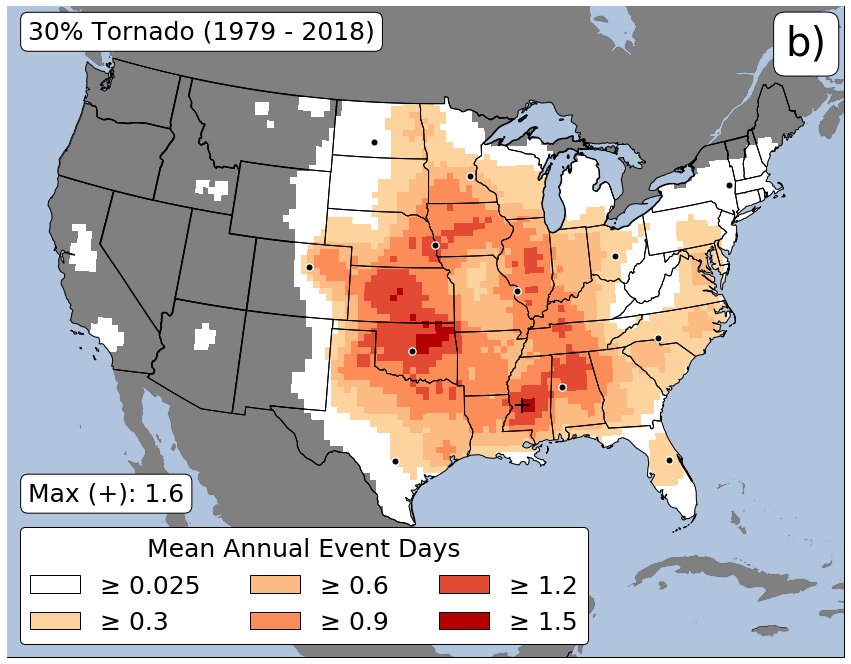

In [4]:
plt.rcParams['figure.figsize'] = 15, 15

dset = xr.open_dataset('../data/tor_day_footprints_79-18_sid-212_grid.nc')

dy_colors = ['#ffffff','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000']

scale = {'pp_30': [0.025, .3,  .6,   .9,   1.2,   1.5,   100]}

var = {'pp_30': '30%'}

for v, name in var.items():
    
    title = "Mean Annual Event Days"
    
    key = '{} Tornado'.format(name)
    
    pper_scale = scale[v]

    dsub = dset[v].groupby('time.year').sum('time')
    dsub = dsub.mean('year')

    x, y = np.where(dsub==dsub.max())
    
    ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

    for mlon, mlat in zip(x, y):
        ax.plot(lons[mlon, mlat], lats[mlon, mlat], "k+", mew=2, ms=15, transform=ccrs.PlateCarree(), zorder=10)
    
    for city_name, city_loc in cities.items():

        ax.plot(city_loc[0], city_loc[1], 'w.', markersize=15, transform=from_proj, zorder=10)
        ax.plot(city_loc[0], city_loc[1], 'k.', markersize=10, transform=from_proj, zorder=10)
        
    txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(1979, 2018), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(plet_x, plet_y, "b)", 
          transform=ax.transAxes, fontsize=40, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.1f}".format(float(np.max(dsub))), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)

    plt.savefig(out_dir + "mean_annual_tor_days_{}.png".format(name, v), bbox_inches='tight', dpi=300)

# Do the same for hail

Set up map params, etc.

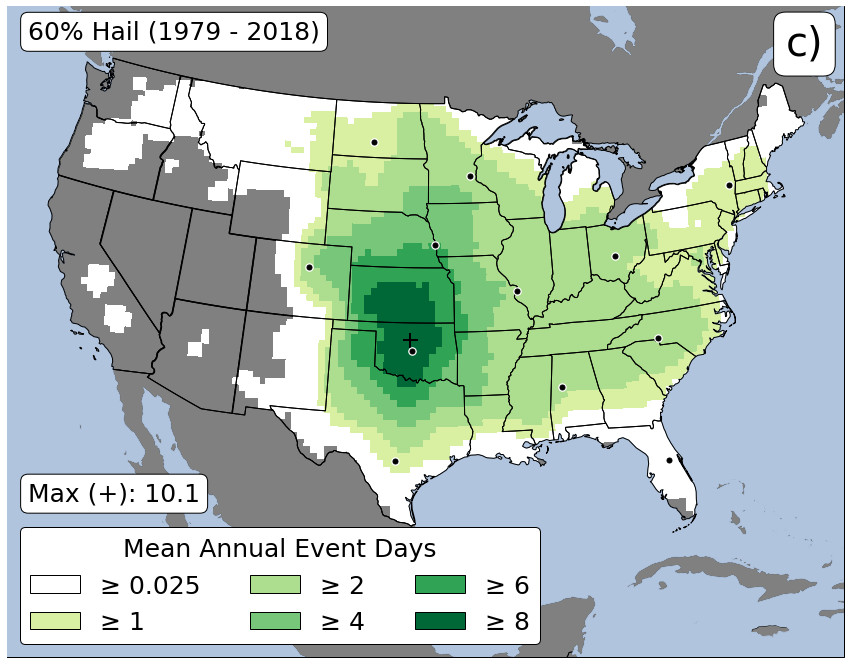

In [5]:
plt.rcParams['figure.figsize'] = 15, 15

dset = xr.open_dataset('../data/hail_day_footprints_79-18_sid-212_grid.nc')

dy_colors = ['#ffffff','#d9f0a3','#addd8e','#78c679','#31a354','#006837']

scale = {'pp_60': [0.025, 1,  2,   4,   6,   8,  100]}

var = {'pp_60': '60%'}

for v, name in var.items():

    title = "Mean Annual Event Days"
    
    key = '{} Hail'.format(name)
    
    pper_scale = scale[v]

    dsub = dset[v].groupby('time.year').sum('time')
    dsub = dsub.mean('year')

    x, y = np.where(dsub==dsub.max())
    
    ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

    for mlon, mlat in zip(x, y):
        ax.plot(lons[mlon, mlat], lats[mlon, mlat], "k+", mew=2, ms=15, transform=ccrs.PlateCarree(), zorder=10)
    
    for city_name, city_loc in cities.items():

        ax.plot(city_loc[0], city_loc[1], 'w.', markersize=15, transform=from_proj, zorder=10)
        ax.plot(city_loc[0], city_loc[1], 'k.', markersize=10, transform=from_proj, zorder=10)
        
    txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(1979, 2018), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(plet_x, plet_y, "c)", 
          transform=ax.transAxes, fontsize=40, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.1f}".format(float(np.max(dsub))), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
        
    plt.savefig(out_dir + "mean_annual_hail_days_{}.png".format(name, v), bbox_inches='tight', dpi=300)

# Do the same for Wind

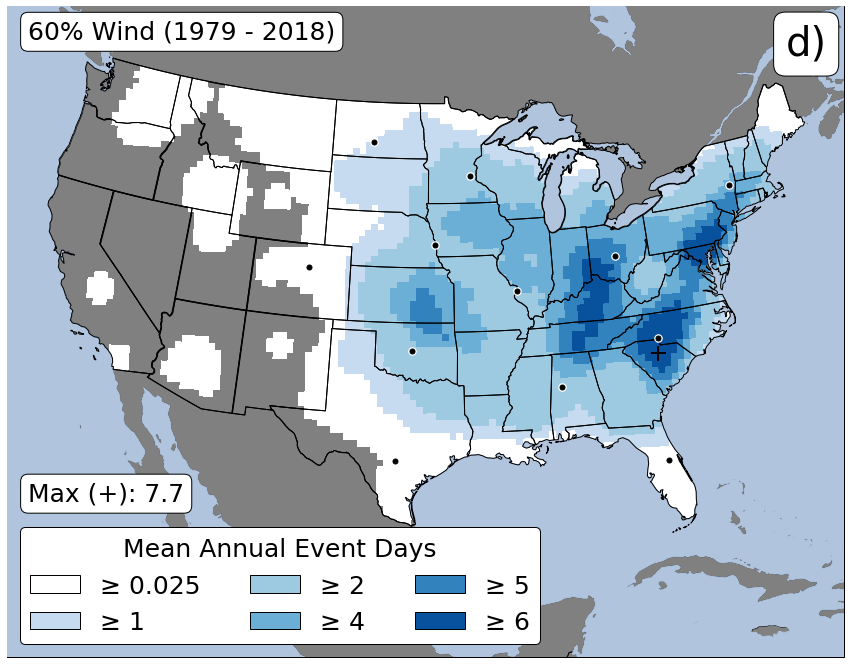

In [6]:
plt.rcParams['figure.figsize'] = 15, 15

dset = xr.open_dataset('../data/wind_day_footprints_79-18_sid-212_grid.nc')

dy_colors = ['#ffffff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']

scale = {'pp_60': [0.025,  1,  2,   4,  5, 6,  100]}

var = {'pp_60': '60%'}

for v, name in var.items():

    title = "Mean Annual Event Days"
    
    key = '{} Wind'.format(name)
    
    pper_scale = scale[v]

    dsub = dset[v].groupby('time.year').sum('time')
    dsub = dsub.mean('year')

    x, y = np.where(dsub==dsub.max())
    
    ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

    for mlon, mlat in zip(x, y):
        ax.plot(lons[mlon, mlat], lats[mlon, mlat], "k+", mew=2, ms=15, transform=ccrs.PlateCarree(), zorder=10)
    
    for city_name, city_loc in cities.items():

        ax.plot(city_loc[0], city_loc[1], 'w.', markersize=15, transform=from_proj, zorder=10)
        ax.plot(city_loc[0], city_loc[1], 'k.', markersize=10, transform=from_proj, zorder=10)
        
    txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(1979, 2018), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(plet_x, plet_y, "d)", 
          transform=ax.transAxes, fontsize=40, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.1f}".format(float(np.max(dsub))), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    plt.savefig(out_dir + "mean_annual_wind_days_{}.png".format(name, v), bbox_inches='tight', dpi=300)

# Combine the data to delineate "Moderate" days

In [7]:
from copy import deepcopy

tor_dset = xr.open_dataset('../data/tor_day_footprints_79-18_sid-212_grid.nc')
hail_dset = xr.open_dataset('../data/hail_day_footprints_79-18_sid-212_grid.nc')
wind_dset = xr.open_dataset('../data/wind_day_footprints_79-18_sid-212_grid.nc')

mdt_tor = deepcopy(tor_dset['pp_30'])
mdt_hail = deepcopy(hail_dset['pp_60'])
mdt_wind = deepcopy(wind_dset['pp_60'])

mdt = 1*((mdt_tor + mdt_hail + mdt_wind)>0)

# Show examples for April 27th 2011

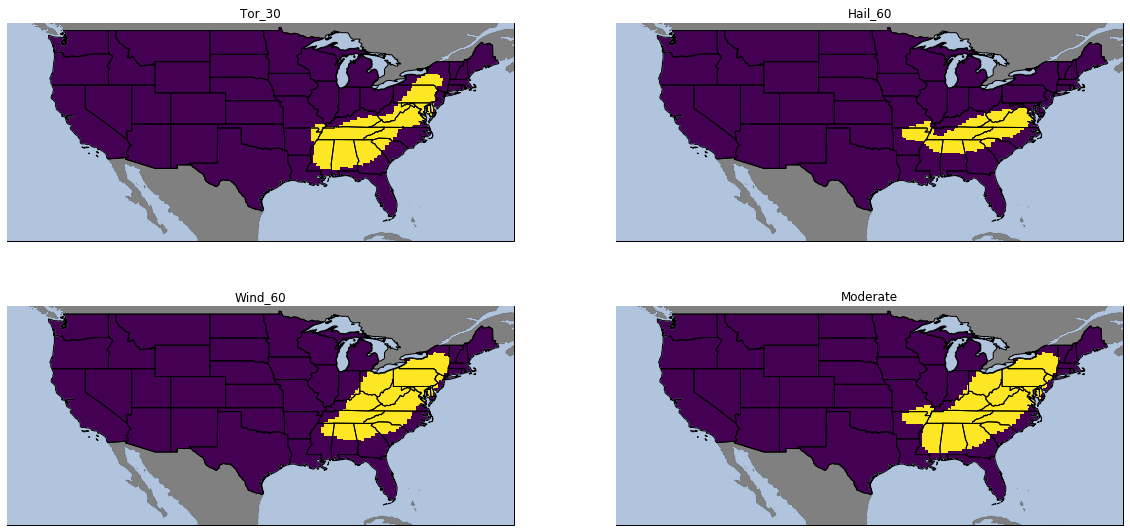

In [8]:
plt.rcParams['figure.figsize'] = 20, 20

fig_ix = 1

for data, label in zip([mdt_tor, mdt_hail, mdt_wind, mdt], ['Tor_30', 'Hail_60', 'Wind_60', 'Moderate']):
    
    ax = plt.subplot(4,2,fig_ix,projection=ccrs.PlateCarree())
    ax.set_extent([-130, -65, 22, 50], crs=ccrs.PlateCarree())
    ax = draw_geography(ax)
    
    data_sub = data.sel(time='2011-04-27')

    ax.pcolormesh(lons, lats, data_sub.values, zorder=6)
    
    ax.set_title(label)
    
    fig_ix += 1

# Draw cases for June 29th 2012

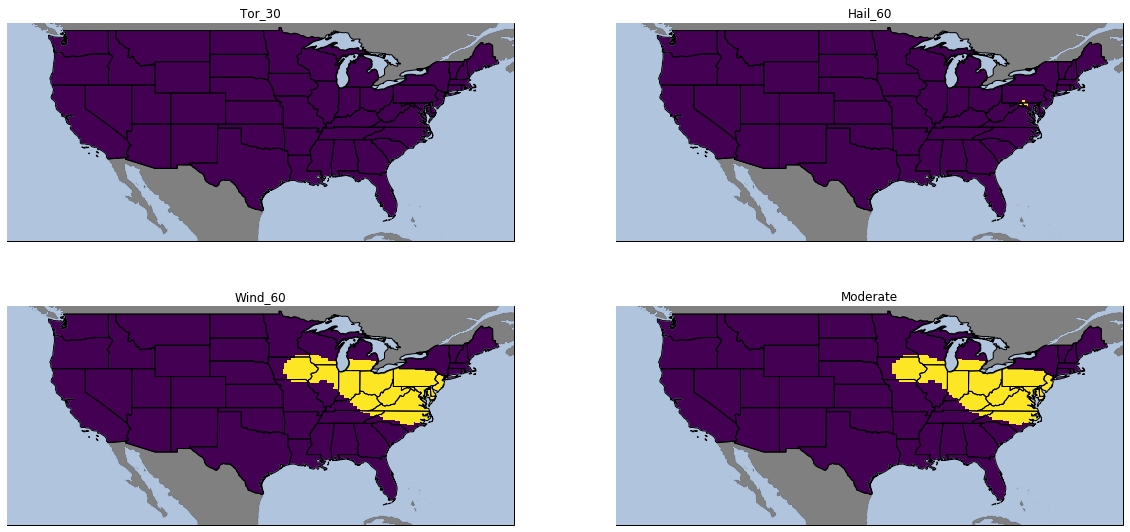

In [9]:
plt.rcParams['figure.figsize'] = 20, 20

fig_ix = 1

for data, label in zip([mdt_tor, mdt_hail, mdt_wind, mdt], ['Tor_30', 'Hail_60', 'Wind_60', 'Moderate']):
    
    ax = plt.subplot(4,2,fig_ix,projection=ccrs.PlateCarree())
    ax.set_extent([-130, -65, 22, 50], crs=ccrs.PlateCarree())
    ax = draw_geography(ax)
    
    data_sub = data.sel(time='2012-06-29')

    ax.pcolormesh(lons, lats, data_sub.values, zorder=6)
    
    ax.set_title(label)
    
    fig_ix += 1

# May 22nd 2011

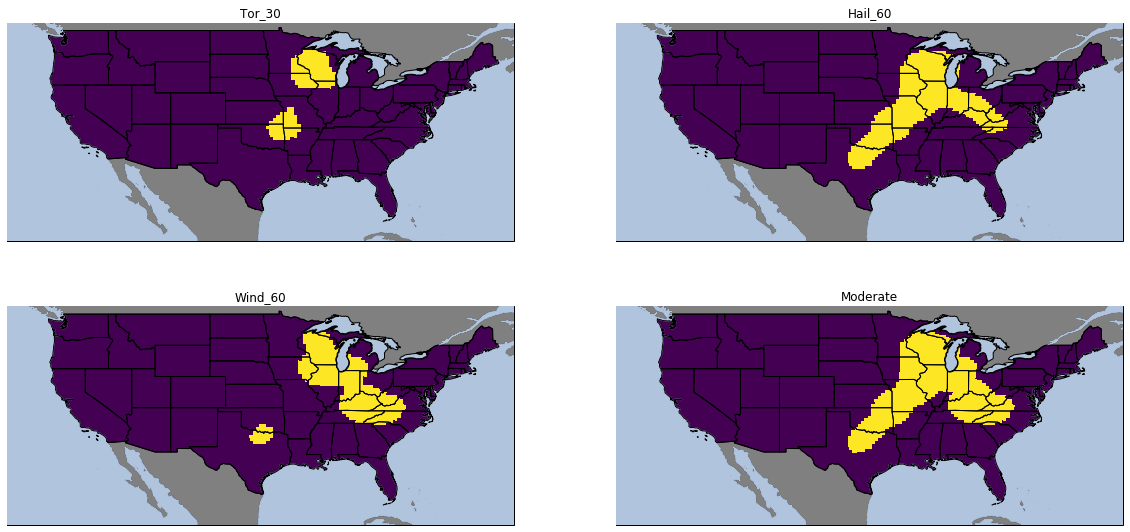

In [10]:
plt.rcParams['figure.figsize'] = 20, 20

fig_ix = 1

for data, label in zip([mdt_tor, mdt_hail, mdt_wind, mdt], ['Tor_30', 'Hail_60', 'Wind_60', 'Moderate']):
    
    ax = plt.subplot(4,2,fig_ix,projection=ccrs.PlateCarree())
    ax.set_extent([-130, -65, 22, 50], crs=ccrs.PlateCarree())
    ax = draw_geography(ax)
    
    data_sub = data.sel(time='2011-05-22')

    ax.pcolormesh(lons, lats, data_sub.values, zorder=6)
    
    ax.set_title(label)
    
    fig_ix += 1

# Draw maps for moderate

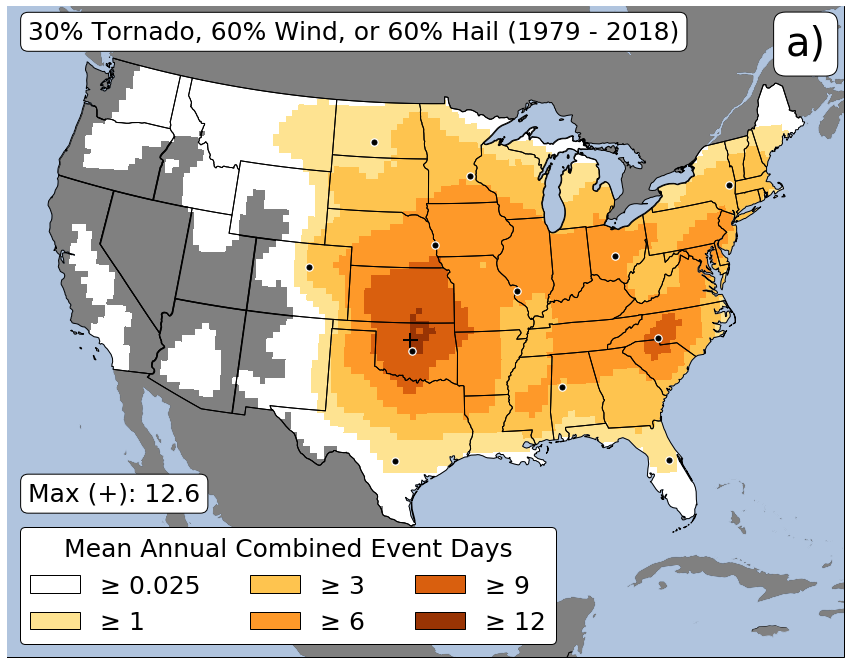

In [11]:
plt.rcParams['figure.figsize'] = 15, 15

dy_colors = ['#ffffff','#fee391','#fec44f','#fe9929','#d95f0e','#993404']

scale = {"mod":[0.025, 1, 3, 6, 9, 12, 100]}

var = {'mod': '30% Tornado, 60% Wind, or 60% Hail'}

for v, name in var.items():

    title = "Mean Annual Combined Event Days"
    
    key = '{}'.format(name)

    pper_scale = scale[v]

    dsub = mdt.groupby('time.year').sum('time')
    dsub = dsub.mean('year')

    x, y = np.where(dsub==dsub.max())
    
    ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

    for mlon, mlat in zip(x, y):
        ax.plot(lons[mlon, mlat], lats[mlon, mlat], "k+", mew=2, ms=15, transform=ccrs.PlateCarree(), zorder=10)
    
    for city_name, city_loc in cities.items():

        ax.plot(city_loc[0], city_loc[1], 'w.', markersize=15, transform=from_proj, zorder=10)
        ax.plot(city_loc[0], city_loc[1], 'k.', markersize=10, transform=from_proj, zorder=10)
        
    txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(1979, 2018), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(plet_x, plet_y, "a)", 
          transform=ax.transAxes, fontsize=40, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
    
    txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.1f}".format(float(np.max(dsub))), 
          transform=ax.transAxes, fontsize=25, 
          bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)

    plt.savefig(out_dir + "mean_annual_{}_days_{}.png".format(name, v), bbox_inches='tight', dpi=300)
    